In [19]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
from funzioni import compute_dataset_weighted
from funzioni import compute_annual_mean_weighted
from funzioni import convert_dataset_celsius
from funzioni import compute_anomaly
from funzioni import create_djf_dataset
from funzioni import compute_mean_time_season
from funzioni import compute_mean_resample_mar
from funzioni import plot_bias_atmos
from funzioni import plot_bias_tos
from funzioni import plot_mean_cluster_atmos
from funzioni import plot_mean_cluster_tos
from funzioni import plot_bias_2_models_atmos
from funzioni import plot_bias_2_models_tos
from funzioni import plot_std_cluster_atmos
from funzioni import plot_zonmean
from funzioni import plot_zonmean_2_cluster
from funzioni import plot_mean_cluster_zonmean
from funzioni import plot_std_cluster_tos
from funzioni import plot_std_cluster_zonmean
from funzioni import bs_sample_mean
from funzioni import bs_compute_array_mean_std_95cl
from funzioni import plot_bs_95cl_mean_std
from funzioni import bs_compute_matrix10
from funzioni import plot_bs_mean_cluster_matrix10
from funzioni import plot_bs_diff_cluster
from funzioni import compute_mean
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pylab as pl
import plotly.express as px
import dill
import pickle
import cartopy.crs as ccrs
import random
from matplotlib.lines import Line2D
from scipy import stats

Caricamento dei file pickle

In [20]:
# Caricamento di models e models_atmos
with open('models_atmos.pkl','rb') as file:
    models_atmos = dill.load(file)
    era_na_seas_mean = dill.load(file)    
with open('models_zonmean.pkl','rb') as file:
    models_zonmean = dill.load(file)
    era_seas_mean = dill.load(file)
with open('modelli_atmos.pickle', 'rb') as f:
    # Caricamento delle 5 liste contenenti i nomi dei modelli all'interno dei 5 cluster
    list_cluster0 = pickle.load(f)
    list_cluster1 = pickle.load(f)
    list_cluster2 = pickle.load(f)
    list_cluster3 = pickle.load(f)
    
    # Caricamento dei 5 cluster in formato pdf
    atmos_cluster0 = pickle.load(f)
    atmos_cluster1 = pickle.load(f)
    atmos_cluster2 = pickle.load(f)
    atmos_cluster3 = pickle.load(f)
    
    # Caricamento dei cluster medi in formato pdf
    atmos_cluster0_mean = pickle.load(f)
    atmos_cluster1_mean = pickle.load(f)
    atmos_cluster2_mean = pickle.load(f)
    atmos_cluster3_mean = pickle.load(f)

    #Caricamento dei cluster standard deviation in formato pdf
    atmos_cluster0_std = pickle.load(f)
    atmos_cluster1_std = pickle.load(f)
    atmos_cluster2_std = pickle.load(f)
    atmos_cluster3_std = pickle.load(f)

with open('modelli_zonmean.pickle','rb') as f:
    #Caricamento dei 5 cluster in formato pdf
    zonmean_cluster0 = pickle.load(f)
    zonmean_cluster1 = pickle.load(f)
    zonmean_cluster2 = pickle.load(f)
    zonmean_cluster3 = pickle.load(f)
    #Caricamento dei cluster medi in formato pdf
    zonmean_cluster0_mean = pickle.load(f)
    zonmean_cluster1_mean = pickle.load(f)
    zonmean_cluster2_mean = pickle.load(f)
    zonmean_cluster3_mean = pickle.load(f)

In [21]:
with open('models.pkl', 'rb') as file:
    models = dill.load(file)
    esa_na_seas_mean_tos = dill.load(file)
    dataset_ESA_na_celsius = dill.load(file)

Risoluzione del modulo oceanico

OSS: Per il conto del numero dei punti griglia nei modelli con griglia curvilinea/lonlat considero soltanto la parte di oceano, quindi tolgo i NaN

In [22]:
#Voglio trovare la risoluzione del singolo modello per il modulo oceanico --> considero il file .nc (no remap)
for name in models.keys():
    path = models[name]['path']
    if os.path.exists(path): #Se il file esiste
        # Apro il dataset
        models[name]['dataset original'] = xr.open_dataset(path) #file .nc
        models[name]['dataset original'] = models[name]['dataset original']['tos'].sel(time=slice("1982-01", "2014-12"))
    else:
        print(f"Errore: Il file {path} non esiste per il modello {name}")

In [23]:
for name in models.keys():
    print(name)
    print(models[name]['dataset original'].coords)

TaiESM1
Coordinates:
  * time       (time) object 3kB 1982-01-16 12:00:00 ... 2014-12-16 12:00:00
    longitude  (j, i) float64 983kB ...
    latitude   (j, i) float64 983kB ...
  * i          (i) float64 3kB 0.0 1.0 2.0 3.0 4.0 ... 316.0 317.0 318.0 319.0
  * j          (j) float64 3kB 0.0 1.0 2.0 3.0 4.0 ... 380.0 381.0 382.0 383.0
AWI-CM-1-1-MR
Coordinates:
  * time     (time) datetime64[ns] 3kB 1982-01-16T12:00:00 ... 2014-12-16T12:...
    lon      (ncells) float64 7MB ...
    lat      (ncells) float64 7MB ...
AWI-ESM-1-1-LR
Coordinates:
  * time     (time) datetime64[ns] 3kB 1982-01-16T12:00:00 ... 2014-12-16T12:...
    lon      (ncells) float64 1MB ...
    lat      (ncells) float64 1MB ...
BCC-CSM2-MR
Coordinates:
  * time       (time) object 3kB 1982-01-16 12:00:00 ... 2014-12-16 12:00:00
    longitude  (lat, lon) float32 334kB ...
    latitude   (lat, lon) float32 334kB ...
  * lon        (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * lat        (lat) flo

In [24]:
#Print delle dimensioni per ogni modello, le dimensioni (eccetto 'time') servono per calcolare la risoluzione
for name in models.keys():
    print(name)
    print(models[name]['dataset original'].dims)

TaiESM1
('time', 'j', 'i')
AWI-CM-1-1-MR
('time', 'ncells')
AWI-ESM-1-1-LR
('time', 'ncells')
BCC-CSM2-MR
('time', 'lat', 'lon')
BCC-ESM1
('time', 'lat', 'lon')
CAMS-CSM1-0
('time', 'j', 'i')
CAS-ESM2-0
('time', 'lat', 'lon')
FGOALS-g3
('time', 'j', 'i')
CanESM5
('time', 'j', 'i')
CMCC-CM2-SR5
('time', 'i', 'j')
ACCESS-ESM1-5
('time', 'j', 'i')
ACCESS-CM2
('time', 'j', 'i')
E3SM-1-0
('time', 'lat', 'lon')
EC-Earth3
('time', 'j', 'i')
EC-Earth3-Veg
('time', 'j', 'i')
FIO-ESM-2-0
('time', 'j', 'i')
MPI-ESM-1-2-HAM
('time', 'j', 'i')
IPSL-CM6A-LR
('time', 'y', 'x')
MIROC6
('time', 'y', 'x')
MPI-ESM1-2-HR
('time', 'j', 'i')
MPI-ESM1-2-LR
('time', 'j', 'i')
MRI-ESM2-0
('time', 'y', 'x')
GISS-E2-1-G
('time', 'lat', 'lon')
GISS-E2-1-G-CC
('time', 'lat', 'lon')
GISS-E2-1-H
('time', 'lat', 'lon')
CESM2
('time', 'nlat', 'nlon')
CESM2-FV2
('time', 'nlat', 'nlon')
CESM2-WACCM
('time', 'lat', 'lon')
CESM2-WACCM-FV2
('time', 'nlat', 'nlon')
NorESM2-LM
('time', 'j', 'i')
NorESM2-MM
('time', 'j', 'i')

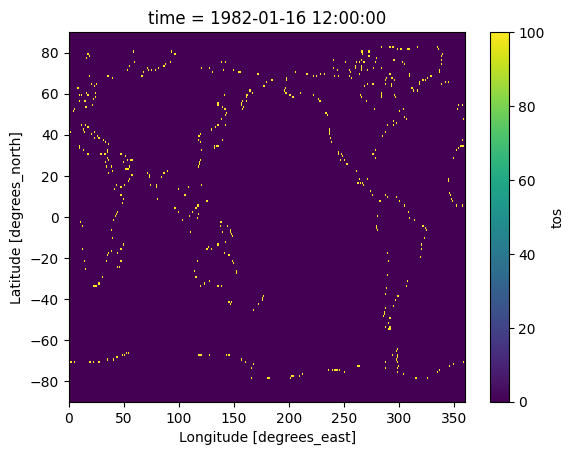

In [25]:
#Metto tutti i nan = 100, tutto il resto = 0
data = models['E3SM-1-0']['dataset original'].isel(time=0)

# Sostituire NaN con 100 e gli altri valori con 0
data_nan = xr.where(np.isnan(data), 100, 0)

# Plottare il risultato
data_nan.plot()

In [26]:
#Calcolo del numero dei punti griglia per ogni modello : non considero la dimensione 'time'
for name in models.keys():
    if len(models[name]['dataset original'].shape) == 2: #cioè soltanto un'altra dimensione oltre a 'time'. In questo caso considero soltanto i due modelli AI, che hanno griglia unstructured
        models[name]['number of grid points'] = (models[name]['dataset original'].shape)[1] #cioè il numero di punti griglia è pari alla seconda dimensione, non considero 'time'
    else:
        dataset = models[name]['dataset original'] #non considero la dimensione 'time'
        #Numero totale dei punti griglia
        models[name]['number of grid points'] = ((dataset.values)).shape[1] * ((dataset.values)).shape[2] #1,2 perché non voglio la coordianta 'time' che è la 0
        #Tolgo i nan
        #Per il modello 'E3SM-1-0' si hanno valori 1. sulla land, li sostituisco quindi con 'nan' per poi togliere tutti i nan
        if name == 'E3SM-1-0':
            models[name]['dataset original'] = xr.where(models[name]['dataset original'] == 1.,np.nan,models[name]['dataset original'])
        n_nan = np.isnan(dataset[0].values).sum() #non considero la dimensione tempo
        models[name]['number of grid points'] = models[name]['number of grid points'] - n_nan
        if name == 'E3SM-1-0' or name == 'GISS-E2-1-G' or name == 'GISS-E2-1-G-CC' or name =='GISS-E2-1-H' or name == 'CESM2-WACCM':
            print(name,models[name]['number of grid points'])

E3SM-1-0 64287
GISS-E2-1-G 8945
GISS-E2-1-G-CC 8945
GISS-E2-1-H 9329
CESM2-WACCM 42491


In [27]:
#Calcolo della risoluzione per ogni modello: area superficie oceanica diviso il numero di punti griglia, tutto sotto radice quadrata
#Superficie oceanica = 360 700 000 km^2
sup_ocean = 360700000 #km^2
for name in models.keys():
    models[name]['model resolution'] = np.sqrt(sup_ocean / models[name]['number of grid points'])
    print(models[name]['model resolution'],name)

64.68285951284905 TaiESM1
20.84271281464916 AWI-CM-1-1-MR
53.32273652730264 AWI-ESM-1-1-LR
79.43775483315298 BCC-CSM2-MR
79.43775483315298 BCC-ESM1
85.77657464121633 CAMS-CSM1-0
86.02170252895544 CAS-ESM2-0
81.65644987369072 FGOALS-g3
74.45479623774334 CanESM5
74.34347918648554 CMCC-CM2-SR5
71.89544314333551 ACCESS-ESM1-5
71.89544314333551 ACCESS-CM2
74.90511780482974 E3SM-1-0
74.18337711874607 EC-Earth3
74.18337711874607 EC-Earth3-Veg
64.68285951284905 FIO-ESM-2-0
99.01529255150761 MPI-ESM-1-2-HAM
74.32525941984572 IPSL-CM6A-LR
80.43891721231057 MIROC6
41.59667140308346 MPI-ESM1-2-HR
99.01529255150761 MPI-ESM1-2-LR
62.62600381242816 MRI-ESM2-0
200.80887297533258 GISS-E2-1-G
200.80887297533258 GISS-E2-1-G-CC
196.63260129150385 GISS-E2-1-H
64.72641952767587 CESM2
64.72641952767587 CESM2-FV2
92.13499044186052 CESM2-WACCM
64.72641952767587 CESM2-WACCM-FV2
64.49758992369287 NorESM2-LM
64.49758992369287 NorESM2-MM
36.58448192862879 GFDL-ESM4
74.30591558788839 NESM3
64.68285951284905 SAM0-UN

Root mean square error

In [28]:
#calcolo il Root mean square error (rmse) del bias di SST nella regione del Nord Atlantico, per ogni modello --> non va bene perché il numero dei punti griglis lo ho calcolato su tutto il globo, non solo sul Nord atlantico
for name in models.keys():
    sum_bias = 0
    sum_bias = np.sum(models[name]['North Atlantic bias DJF'])
    models[name]['rms error'] = np.sqrt((1/models[name]['number of grid points'])*(sum_bias**2)) #rmse per ogni modello, vedo quanto ogni modello fa bene
    print(name,models[name]['rms error'])

TaiESM1 <xarray.DataArray ()> Size: 8B
array(1.22416283)
AWI-CM-1-1-MR <xarray.DataArray ()> Size: 8B
array(0.0565201)
AWI-ESM-1-1-LR <xarray.DataArray ()> Size: 8B
array(1.24174307)
BCC-CSM2-MR <xarray.DataArray ()> Size: 8B
array(0.6969983)
BCC-ESM1 <xarray.DataArray ()> Size: 8B
array(0.69725543)
CAMS-CSM1-0 <xarray.DataArray ()> Size: 8B
array(6.98644431)
CAS-ESM2-0 <xarray.DataArray ()> Size: 8B
array(0.53662767)
FGOALS-g3 <xarray.DataArray ()> Size: 8B
array(1.27504215)
CanESM5 <xarray.DataArray ()> Size: 8B
array(3.18237277)
CMCC-CM2-SR5 <xarray.DataArray ()> Size: 8B
array(0.75907153)
ACCESS-ESM1-5 <xarray.DataArray ()> Size: 8B
array(2.04450425)
ACCESS-CM2 <xarray.DataArray ()> Size: 8B
array(1.69854997)
E3SM-1-0 <xarray.DataArray ()> Size: 8B
array(4.37942392)
EC-Earth3 <xarray.DataArray ()> Size: 8B
array(1.76683264)
EC-Earth3-Veg <xarray.DataArray ()> Size: 8B
array(0.24452511)
FIO-ESM-2-0 <xarray.DataArray ()> Size: 8B
array(0.33440181)
MPI-ESM-1-2-HAM <xarray.DataArray ()

In [29]:
#risoluzione dei modelli come visto dal report IPCC: the area of the ocean surface divided by the number of surface ocean grid points
#La risoluzione è in km
resol_ipcc = [60,20,50,80,80,90,80,80,70,70,70,70,40,70,70,60,100,70,80,40,100,60,100,100,70,60,60,60,60,60,60,40,70,60,190]
k = 0 #indice dell'array resol_ipcc
for name in models.keys():
    models[name]['model resolution ipcc'] = resol_ipcc[k]
    k = k + 1

Plot rmse - risoluzione

Text(0.5, 0.98, 'SST: Scatter plot models resolution')

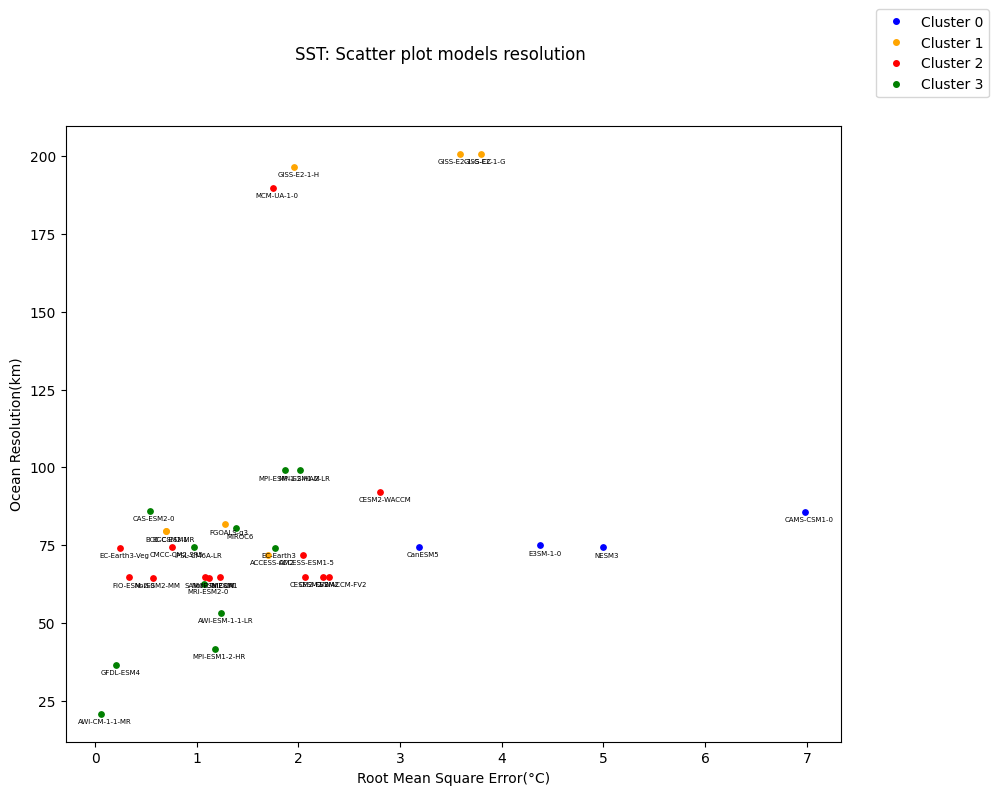

In [30]:
#rmse - resolution plot
list_clusters = [list_cluster0,list_cluster1,list_cluster2,list_cluster3]
fig,ax = plt.subplots(figsize=(10,8))
colour_list_sst = ['blue','orange','red','green']
for name in models.keys():
    for n in range(len(list_clusters)): #ciclo sui cluster
        if name in list_clusters[n]: #se un modello appartiene ad un determinato cluster
            ax.scatter(models[name]['rms error'],models[name]['model resolution'],s=15,color=colour_list_sst[n])
            ax.annotate(name, (models[name]['rms error'],models[name]['model resolution']),
                        textcoords="offset points", xytext=(3,-7), ha='center',fontsize=5)
#Legenda
legends = []
for n in range(len(list_clusters)):
    legend = Line2D([0], [0], color=colour_list_sst[n], lw=0, marker='o', markersize=4, label=f'Cluster {n}')  
    legends.append(legend)
ax.legend(handles=legends, loc='upper right', bbox_to_anchor=(1.2, 1.2), ncol=1)
#Label assi e titolo
ax.set_xlabel('Root Mean Square Error(°C)')
ax.set_ylabel('Ocean Resolution(km)')
fig.suptitle('SST: Scatter plot models resolution')

Text(0.5, 0.98, 'SST: Scatter plot models resolution IPCC')

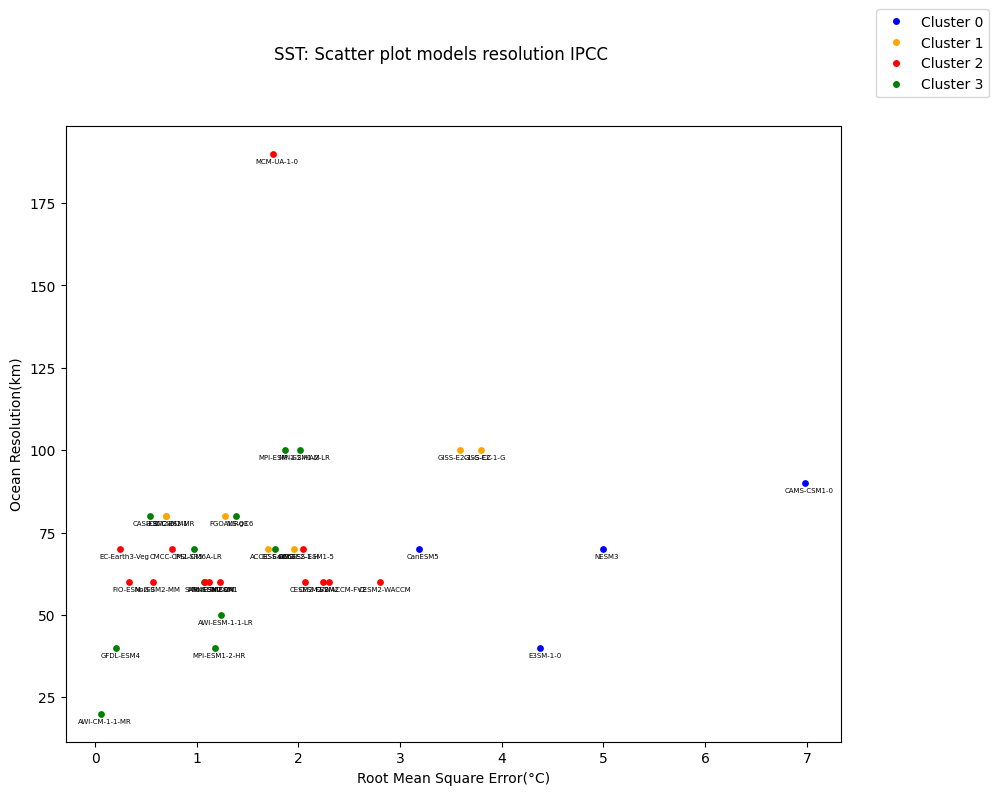

In [31]:
#IPCC
#rmse - resolution plot
fig,ax = plt.subplots(figsize=(10,8))
for name in models.keys():
    for n in range(len(list_clusters)): #ciclo sui cluster
        if name in list_clusters[n]: #se un modello appartiene ad un determinato cluster
            ax.scatter(models[name]['rms error'],models[name]['model resolution ipcc'],s=15,color=colour_list_sst[n])
            ax.annotate(name, (models[name]['rms error'],models[name]['model resolution ipcc']),
                        textcoords="offset points", xytext=(3,-7), ha='center',fontsize=5)
#Legenda
legends = []
for n in range(len(list_clusters)):
    legend = Line2D([0], [0], color=colour_list_sst[n], lw=0, marker='o', markersize=4, label=f'Cluster {n}')  
    legends.append(legend)
ax.legend(handles=legends, loc='upper right', bbox_to_anchor=(1.2, 1.2), ncol=1)
#Label assi e titolo
ax.set_xlabel('Root Mean Square Error(°C)')
ax.set_ylabel('Ocean Resolution(km)')
fig.suptitle('SST: Scatter plot models resolution IPCC')

850 hPa

Risoluzione del modulo atmosferico

In [32]:
#Voglio trovare la risoluzione del singolo modello per il modulo oceanico --> considero il file .nc (no remap)
for name in models_atmos.keys():
    path = models_atmos[name]['atmos path']
    if os.path.exists(path): #Se il file esiste
        # Apro il dataset
        models_atmos[name]['atmos dataset original'] = xr.open_dataset(path) #file .nc
        models_atmos[name]['atmos dataset original'] = models_atmos[name]['atmos dataset original']['ua'].sel(time=slice("1982-01", "2014-12"))
    else:
        print(f"Errore: Il file {path} non esiste per il modello {name}")

In [33]:
for name in models_atmos.keys():
    print(name)
    print(models_atmos[name]['atmos dataset original'].coords)

TaiESM1
Coordinates:
  * time     (time) object 3kB 1982-01-16 12:00:00 ... 2014-12-16 12:00:00
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * plev     (plev) float64 8B 8.5e+04
AWI-CM-1-1-MR
Coordinates:
  * time     (time) datetime64[ns] 3kB 1982-01-16T12:00:00 ... 2014-12-16T12:...
  * lon      (lon) float64 3kB 0.0 0.9375 1.875 2.812 ... 357.2 358.1 359.1
  * lat      (lat) float64 2kB -89.28 -88.36 -87.42 -86.49 ... 87.42 88.36 89.28
  * plev     (plev) float64 8B 8.5e+04
AWI-ESM-1-1-LR
Coordinates:
  * time     (time) datetime64[ns] 3kB 1982-01-16T12:00:00 ... 2014-12-16T12:...
  * lon      (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * lat      (lat) float64 768B -88.57 -86.72 -84.86 -83.0 ... 84.86 86.72 88.57
  * plev     (plev) float64 8B 8.5e+04
BCC-CSM2-MR
Coordinates:
  * time     (time) object 3kB 1982-01-16 12:00:00 ... 2014-12-16 1

In [34]:
#Print delle dimensioni per ogni modello, le dimensioni (eccetto 'time' e 'plev') servono per calcolare la risoluzione
for name in models_atmos.keys():
    print(name)
    print(models_atmos[name]['atmos dataset original'].dims)

TaiESM1
('time', 'plev', 'lat', 'lon')
AWI-CM-1-1-MR
('time', 'plev', 'lat', 'lon')
AWI-ESM-1-1-LR
('time', 'plev', 'lat', 'lon')
BCC-CSM2-MR
('time', 'plev', 'lat', 'lon')
BCC-ESM1
('time', 'plev', 'lat', 'lon')
CAMS-CSM1-0
('time', 'plev', 'lat', 'lon')
CAS-ESM2-0
('time', 'plev', 'lat', 'lon')
FGOALS-g3
('time', 'plev', 'lat', 'lon')
CanESM5
('time', 'plev', 'lat', 'lon')
CMCC-CM2-SR5
('time', 'plev', 'lat', 'lon')
ACCESS-ESM1-5
('time', 'plev', 'lat', 'lon')
ACCESS-CM2
('time', 'plev', 'lat', 'lon')
E3SM-1-0
('time', 'plev', 'lat', 'lon')
EC-Earth3
('time', 'plev', 'lat', 'lon')
EC-Earth3-Veg
('time', 'plev', 'lat', 'lon')
FIO-ESM-2-0
('time', 'plev', 'lat', 'lon')
MPI-ESM-1-2-HAM
('time', 'plev', 'lat', 'lon')
IPSL-CM6A-LR
('time', 'plev', 'lat', 'lon')
MIROC6
('time', 'plev', 'lat', 'lon')
MPI-ESM1-2-HR
('time', 'plev', 'lat', 'lon')
MPI-ESM1-2-LR
('time', 'plev', 'lat', 'lon')
MRI-ESM2-0
('time', 'plev', 'lat', 'lon')
GISS-E2-1-G
('time', 'plev', 'lat', 'lon')
GISS-E2-1-G-CC
('t

In [35]:
#Calcolo del numero dei punti griglia per ogni modello : non considero la dimensione 'time' e 'plev'
for name in models_atmos.keys():
    models_atmos[name]['atmos number of grid points'] = (models_atmos[name]['atmos dataset original'].shape)[2] * (models_atmos[name]['atmos dataset original'].shape)[3] #1,2 perché non voglio la coordianta 'time' che è la 0
    #Tolgo i nan
    dataset = models_atmos[name]['atmos dataset original']
    n_nan = np.isnan(dataset[0].values).sum() #non considero la dimensione tempo
    models_atmos[name]['atmos number of grid points'] = models_atmos[name]['atmos number of grid points'] - n_nan

In [36]:
#Calcolo della risoluzione per ogni modello: area superficie terrestre diviso il numero di punti griglia, tutto sotto radice quadrata
#Area superficie terrestre = 360 700 000 km^2
sup_earth = 510100000 #km^2
for name in models_atmos.keys():
    models_atmos[name]['atmos model resolution'] = np.sqrt(sup_earth / models_atmos[name]['atmos number of grid points'])
    print(models_atmos[name]['atmos model resolution'],name)

96.04633635309497 TaiESM1
83.17856722220507 AWI-CM-1-1-MR
166.35713444441015 AWI-ESM-1-1-LR
99.8142806666461 BCC-CSM2-MR
249.53570166661524 BCC-ESM1
99.8142806666461 CAMS-CSM1-0
124.76785083330762 CAS-ESM2-0
196.19455407476642 FGOALS-g3
249.53570166661524 CanESM5
96.04633635309497 CMCC-CM2-SR5
143.6696147420796 ACCESS-ESM1-5
142.87972424424697 ACCESS-CM2
92.95030291329472 E3SM-1-0
62.38392541665381 EC-Earth3
62.38392541665381 EC-Earth3-Veg
96.04633635309497 FIO-ESM-2-0
166.35713444441015 MPI-ESM-1-2-HAM
166.04214053441513 IPSL-CM6A-LR
131.16419945068068 MIROC6
83.17856722220507 MPI-ESM1-2-HR
166.35713444441015 MPI-ESM1-2-LR
105.12683255457158 MRI-ESM2-0
208.98967593557867 GISS-E2-1-G
208.9449540853447 GISS-E2-1-G-CC
208.83773867381166 GISS-E2-1-H
101.57948343843547 CESM2
203.2247513736576 CESM2-FV2
101.54046534957308 CESM2-WACCM
203.04399756671057 CESM2-WACCM-FV2
192.09267270618994 NorESM2-LM
96.04633635309497 NorESM2-MM
103.92797908882396 GFDL-ESM4
166.35713444441015 NESM3
101.5455967

Root mean square error

In [37]:
#calcolo il Root mean square error (rmse) del bias di SST nella regione del Nord Atlantico, per ogni modello
for name in models_atmos.keys():
    sum_bias = 0
    sum_bias = np.sum(models_atmos[name]['atmos North Atlantic bias DJF'])
    models_atmos[name]['atmos rms error'] = np.sqrt((1/models_atmos[name]['atmos number of grid points'])*(sum_bias**2)) #rmse per ogni modello, vedo quanto ogni modello fa bene
    print(name,models_atmos[name]['atmos rms error'])

TaiESM1 <xarray.DataArray ()> Size: 8B
array(1.75327652)
AWI-CM-1-1-MR <xarray.DataArray ()> Size: 8B
array(0.5870747)
AWI-ESM-1-1-LR <xarray.DataArray ()> Size: 8B
array(1.43804354)
BCC-CSM2-MR <xarray.DataArray ()> Size: 8B
array(5.44761048)
BCC-ESM1 <xarray.DataArray ()> Size: 8B
array(0.42546334)
CAMS-CSM1-0 <xarray.DataArray ()> Size: 8B
array(1.91599846)
CAS-ESM2-0 <xarray.DataArray ()> Size: 8B
array(0.37625367)
FGOALS-g3 <xarray.DataArray ()> Size: 8B
array(8.53492408)
CanESM5 <xarray.DataArray ()> Size: 8B
array(12.48682839)
CMCC-CM2-SR5 <xarray.DataArray ()> Size: 8B
array(0.01327311)
ACCESS-ESM1-5 <xarray.DataArray ()> Size: 8B
array(0.9062478)
ACCESS-CM2 <xarray.DataArray ()> Size: 8B
array(6.39504016)
E3SM-1-0 <xarray.DataArray ()> Size: 8B
array(0.84668204)
EC-Earth3 <xarray.DataArray ()> Size: 8B
array(0.01702539)
EC-Earth3-Veg <xarray.DataArray ()> Size: 8B
array(0.02841216)
FIO-ESM-2-0 <xarray.DataArray ()> Size: 8B
array(0.08198895)
MPI-ESM-1-2-HAM <xarray.DataArray (

In [38]:
#risoluzione dei modelli come visto dal report IPCC: the area of the earth surface divided by the number of grid points
#La risoluzione è in km
# CAS-ESM2-0 ?
resol_atmos_ipcc = [100,80,170,100,250,100,120,190,250,100,140,140,100,80,80,100,170,160,250,80,170,100,200,200,200,100,100,100,100,190,100,100,170,100,260]
k = 0 #indice dell'array resol_ipcc
for name in models_atmos.keys():
    models_atmos[name]['atmos model resolution ipcc'] = resol_atmos_ipcc[k]
    k = k + 1

Plot rmse - risoluzione

Text(0.5, 0.98, 'Zonal wind 850hPa: Scatter plot models resolution')

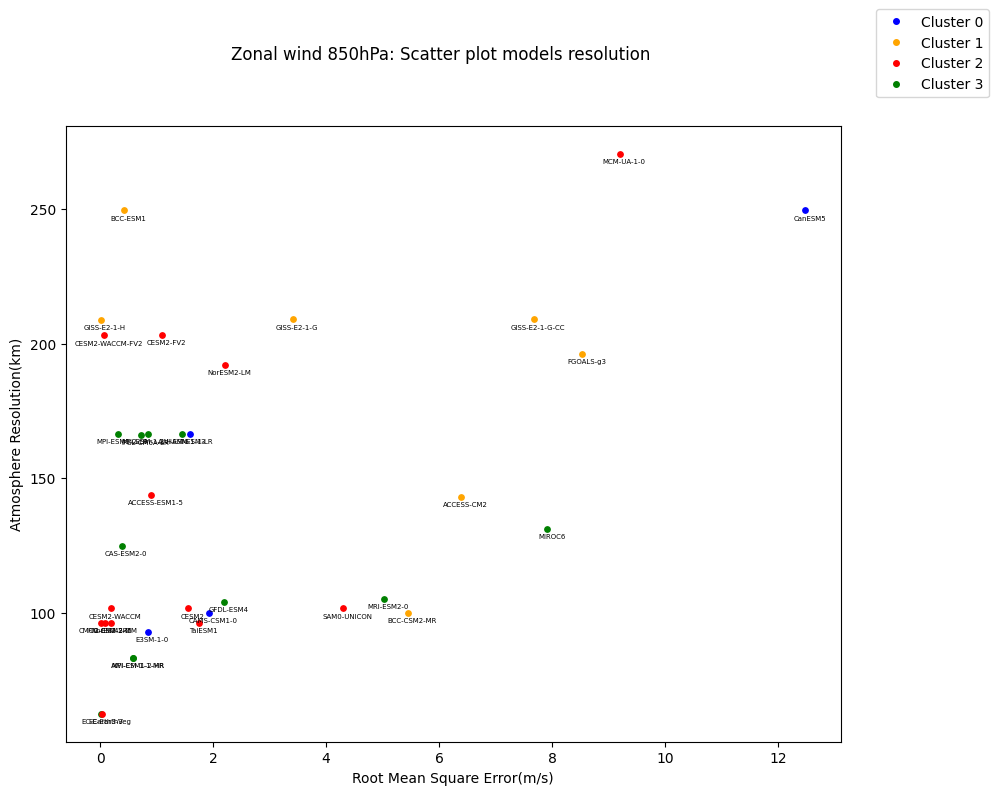

In [39]:
#rmse - resolution plot
fig,ax = plt.subplots(figsize=(10,8))
colour_list_sst = ['blue','orange','red','green']
for name in models_atmos.keys():
    for n in range(len(list_clusters)): #ciclo sui cluster
        if name in list_clusters[n]: #se un modello appartiene ad un determinato cluster
            ax.scatter(models_atmos[name]['atmos rms error'],models_atmos[name]['atmos model resolution'],s=15,color=colour_list_sst[n])
            ax.annotate(name, (models_atmos[name]['atmos rms error'],models_atmos[name]['atmos model resolution']),
                        textcoords="offset points", xytext=(3,-7), ha='center',fontsize=5)
#Legenda
legends = []
for n in range(len(list_clusters)):
    legend = Line2D([0], [0], color=colour_list_sst[n], lw=0, marker='o', markersize=4, label=f'Cluster {n}')  
    legends.append(legend)
ax.legend(handles=legends, loc='upper right', bbox_to_anchor=(1.2, 1.2), ncol=1)
#Label assi e titolo
ax.set_xlabel('Root Mean Square Error(m/s)')
ax.set_ylabel('Atmosphere Resolution(km)')
fig.suptitle('Zonal wind 850hPa: Scatter plot models resolution')

Text(0.5, 0.98, 'Zonal wind 850hPa: Scatter plot models resolution IPCC')

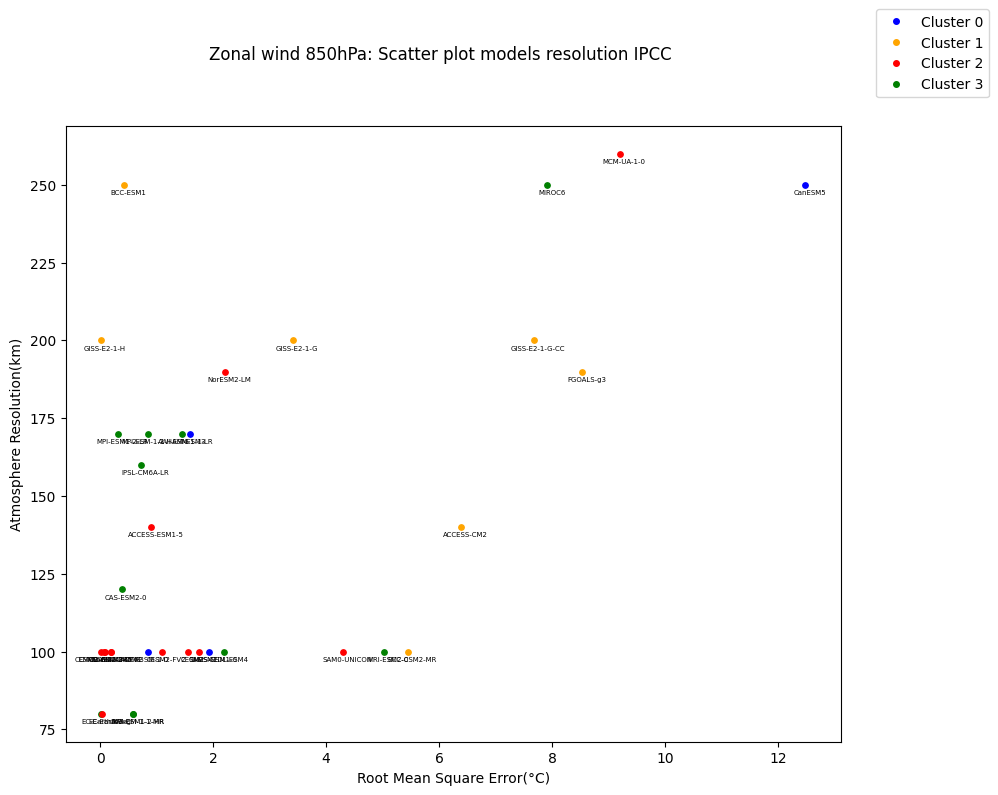

In [40]:
#IPCC
#rmse - resolution plot
fig,ax = plt.subplots(figsize=(10,8))
for name in models_atmos.keys():
    for n in range(len(list_clusters)): #ciclo sui cluster
        if name in list_clusters[n]: #se un modello appartiene ad un determinato cluster
            ax.scatter(models_atmos[name]['atmos rms error'],models_atmos[name]['atmos model resolution ipcc'],s=15,color=colour_list_sst[n])
            ax.annotate(name, (models_atmos[name]['atmos rms error'],models_atmos[name]['atmos model resolution ipcc']),
                        textcoords="offset points", xytext=(3,-7), ha='center',fontsize=5)
#Legenda
legends = []
for n in range(len(list_clusters)):
    legend = Line2D([0], [0], color=colour_list_sst[n], lw=0, marker='o', markersize=4, label=f'Cluster {n}')  
    legends.append(legend)
ax.legend(handles=legends, loc='upper right', bbox_to_anchor=(1.2, 1.2), ncol=1)
#Label assi e titolo
ax.set_xlabel('Root Mean Square Error(°C)')
ax.set_ylabel('Atmosphere Resolution(km)')
fig.suptitle('Zonal wind 850hPa: Scatter plot models resolution IPCC')

Calcolo l'intensità e la latitudine del jet stream per ogni modello nella regione lonxlat = [-60,0]x[20,80]

In [22]:
for name in models_atmos.keys():
    #Seleziono la regione in cui vado a calcolare l'intensità del jet
    models_atmos[name]['atmos box jet'] = models_atmos[name]['atmos North Atlantic box']['ua'].sel(time=slice('1982-01','2014-12'),lat=slice(20,80),lon=slice(-60,0))
    #Calcolo la media climatologica nel solito periodo 1982-2014
    models_atmos[name]['atmos box jet climatology'] = compute_mean_resample_mar(models_atmos[name]['atmos box jet'] ,"1982","2014",3)

Determino il massimo dell'intensità del vento sulla media climatologica, poi faccio multi model mean e cluster mean dei massimi.
Calcolo la latitudine del jet come la latitudine a cui si ha intensità massima del jet

In [23]:
lat_coords = models_atmos['ACCESS-CM2']['atmos box jet climatology'].coords['lat']
n_clusters=4 #numero di cluster
list_clusters = [list_cluster0,list_cluster1,list_cluster2,list_cluster3] #lista con il nome di ogni modello per ogni cluster
intensity_jet_cluster_mean = [] #lista in cui vado a mettere il valore dell'intensità del jet per ogni cluster
latitude_jet_cluster_mean = [] #lista in cui vado a mettere il valore la latitudine del jet per ogni cluster
#Inizializzo xarray per la multi model mean
sum_models_intensity = 0
sum_models_latitude = 0
#CLUSTER
for n in range(n_clusters):  # ciclo su ogni cluster
    #Inizializzo xarray per la cluster mean
    sum_clusters_intensity = 0
    sum_clusters_latitude = 0
    #MODELLI
    for i in range(len(list_clusters[n])):  # ciclo su ogni modello dei singoli cluster
        name = list_clusters[n][i] #nome modello
        #Calcolo media zonale e poi determino il massimo per ogni latitudine
        zonal_mean = models_atmos[name]['atmos box jet climatology'][0,:,:].mean(dim='lon') #0 è il plev a 850hPa            
        models_atmos[name]['jet intensity'] = zonal_mean.max() #il massimo sulla latitudine
        models_atmos[name]['jet latitude'] = (np.nanargmax(zonal_mean))*2 + models_atmos[name]['atmos box jet climatology'].lat[0] #sommo lat[0] per avere il giusto valore di latitudine, *2 perché ogni cella è di 2°
        #Somma per ogni modello per ogni longitudine, di uno specifico cluster
        sum_clusters_intensity = sum_clusters_intensity + models_atmos[name]['jet intensity']
        sum_clusters_latitude = sum_clusters_latitude + models_atmos[name]['jet latitude']
        
    #Clusters' mean per intensità e latitudine
    intensity_jet_cluster_mean.append((sum_clusters_intensity / len(list_clusters[n])))
    latitude_jet_cluster_mean.append((sum_clusters_latitude / len(list_clusters[n])))
    #Somma su tutti i modelli per la model mean    
    sum_models_intensity = sum_models_intensity + sum_clusters_intensity
    sum_models_latitude = sum_models_latitude + sum_clusters_latitude
#Multi model mean di latitudine e intensità
intensity_jet_model_mean = sum_models_intensity / len(models_atmos)
latitude_jet_model_mean = sum_models_latitude / len(models_atmos)

Tilt del jet stream

In [24]:
#Jet tilt
lon_coords = models_atmos['ACCESS-CM2']['atmos box jet climatology'].coords['lon']
sum_models_latitude = 0
longitude_max_jet_cluster_mean = [] #longitudine a cui si ha il massimo del vento
#Inizializzo xarray
#CLUSTER
for n in range(n_clusters):  # ciclo su ogni cluster
    sum_clusters_latitude = xr.DataArray(np.zeros((len(lon_coords))), dims=['lon'], coords={'lon': lon_coords})
    #MODELLI
    for i in range(len(list_clusters[n])):  # ciclo su ogni modello dei singoli cluster
        name = list_clusters[n][i] #nome modello
        #Inizializzazione xarray che contiene il valore della latitudine a cui si ha il massimo del vento, per ogni longitudine
        models_atmos[name]['longitude max jet'] = xr.DataArray(np.empty((len(lon_coords))), dims=['lon'], coords={'lon': lon_coords})
        #Massimo sulla latitudine, per ogni longitudine e tempo
        for j in range(len(models_atmos['ACCESS-CM2']['atmos box jet climatology'].lon)) : #ciclo sulla longitudine
            models_atmos[name]['longitude max jet'][j] = (np.nanargmax(models_atmos[name]['atmos box jet climatology'][0,:,j]))*2 + models_atmos[name]['atmos box jet climatology'].lat[0] #sommo lat[0] per avere il giusto valore di latitudine
            #Somma per ogni modello per ogni longitudine, di uno specifico cluster
            sum_clusters_latitude[j] = sum_clusters_latitude[j] + models_atmos[name]['longitude max jet'][j]
    #Clusters' mean per ogni longitudine
    latitude_jet_cluster_mean.append((sum_clusters_latitude / len(list_clusters[n])))
    #Somma su tutti i modello per ogni longitudine, per la model mean    
    sum_models_latitude = sum_models_latitude + sum_clusters_latitude
#Multi model mean per ogni longitudine
longitude_max_jet_cluster_mean = sum_models_latitude / len(models_atmos)

In [25]:
#Jet tilt linear fit --> fit lineare su tutti i valori massimi del jet per ogni longitudine, per determinare l'angolo di inclinazione
sum_model_mean = 0 #inizializzo per il calcolo del jet tilt per la model mean
jet_tilt_cluster_mean = []
for n in range(len(list_clusters)): #ciclo sui 5 cluster
    sum_cluster_mean = 0 #inizializzo per il calcolo del jet tilt per il valor medio dei cluster
    for i in range(len(list_clusters[n])): #ciclo sui modelli dei cluster
        name = list_clusters[n][i]
        fit = models_atmos[name]['longitude max jet'].polyfit(dim='lon',deg=1)
        #coefficiente angolare
        m = fit.polyfit_coefficients.sel(degree=1)
        #estraggo anngolo da coefficiente angolare
        angle_rad = np.arctan(m)
        models_atmos[name]['jet tilt'] = np.degrees(angle_rad) #array in cui vado a mettere l'angolo di inclinazione del jet per ogni modello
        #per il calcolo del jet tilt per il cluster mean
        sum_cluster_mean = sum_cluster_mean + models_atmos[name]['jet tilt']
        #per il calcolo del jet tilt per la model mean
        sum_model_mean = sum_model_mean + models_atmos[name]['jet tilt']
    jet_tilt_cluster_mean.append(sum_cluster_mean / len(list_clusters[n]))
jet_tilt_model_mean = sum_model_mean / len(models_atmos)

Spread del jet stream

In [26]:
#jet spread
lat_coords = models_atmos['ACCESS-CM2']['atmos box jet climatology'].coords['lat']
sum_multi_model = 0 #Inizializzazione per multi model mean
jet_spread_cluster_mean = []
for n in range(n_clusters):  # ciclo su ogni cluster
    sum_cluster = 0 #Inizializzazione per cluster mean
    for i in range(len(list_clusters[n])):  # ciclo su ogni modello dei singoli cluster
        name = list_clusters[n][i]
        models_atmos[name]['jet spread'] = xr.DataArray(np.empty((len(lat_coords))), dims=['lat'], coords={'lat': lat_coords})
        models_atmos[name]['jet spread'] = models_atmos[name]['atmos box jet climatology'][0,:,:].mean(dim='lon') #0 è il plev a 850hPa
        sum_cluster = sum_cluster + models_atmos[name]['jet spread']
        sum_multi_model = sum_multi_model + models_atmos[name]['jet spread']
    jet_spread_cluster_mean.append(sum_cluster / len(list_clusters[n]))
jet_spread_model_mean = (sum_multi_model / len(models_atmos))           

In [27]:
#Prendo soltanto la parte del jet stream, cioè quella con valori positivi (westerlies)
#Modelli
for name in models_atmos.keys():
    lat_initial = models_atmos[name]['jet spread'].lat[0].values
    lat_final = models_atmos[name]['jet spread'].lat[-1].values
    for i in range(1, len(models_atmos[name]['jet spread'].lat.values) - 1):
        if models_atmos[name]['jet spread'].values[i] >= 0 and models_atmos[name]['jet spread'].values[i - 1] < 0:
            if models_atmos[name]['jet spread'].lat.values[i] < lat_final:
                lat_initial = models_atmos[name]['jet spread'].lat.values[i]
        if models_atmos[name]['jet spread'].values[i] >= 0 and models_atmos[name]['jet spread'].values[i + 1] < 0:
            lat_final = models_atmos[name]['jet spread'].lat.values[i]
    models_atmos[name]['jet spread'] = models_atmos[name]['jet spread'].sel(lat=slice(lat_initial,lat_final))
#Cluster
for n in range(n_clusters):
    lat_initial = jet_spread_cluster_mean[n].lat[0].values
    lat_final = jet_spread_cluster_mean[n].lat[-1].values
    for i in range(1, len(jet_spread_cluster_mean[n].lat.values) - 1):
        if jet_spread_cluster_mean[n].values[i] >= 0 and jet_spread_cluster_mean[n].values[i - 1] < 0:
            if jet_spread_cluster_mean[n].lat.values[i] < lat_final:
                lat_initial = jet_spread_cluster_mean[n].lat.values[i]
        if jet_spread_cluster_mean[n].values[i] >= 0 and jet_spread_cluster_mean[n].values[i + 1] < 0:
            lat_final = jet_spread_cluster_mean[n].lat.values[i]
    jet_spread_cluster_mean[n] = jet_spread_cluster_mean[n].sel(lat=slice(lat_initial,lat_final))
#Model mean
lat_initial = jet_spread_model_mean.lat[0].values
lat_final = jet_spread_model_mean.lat[-1].values
for i in range(1, len(jet_spread_model_mean.lat.values) - 1):
    if jet_spread_model_mean.values[i] >= 0 and jet_spread_model_mean.values[i - 1] < 0:
        if jet_spread_model_mean.lat.values[i] < lat_final:
            lat_initial = jet_spread_model_mean.lat.values[i]
    if jet_spread_model_mean.values[i] >= 0 and jet_spread_model_mean.values[i + 1] < 0:
        lat_final = jet_spread_model_mean.lat.values[i]
jet_spread_model_mean = jet_spread_model_mean.sel(lat=slice(lat_initial,lat_final))

In [28]:
models_list_atmos = list(models_atmos.keys())

Text(0.5, 0.9, 'Jet Spread')

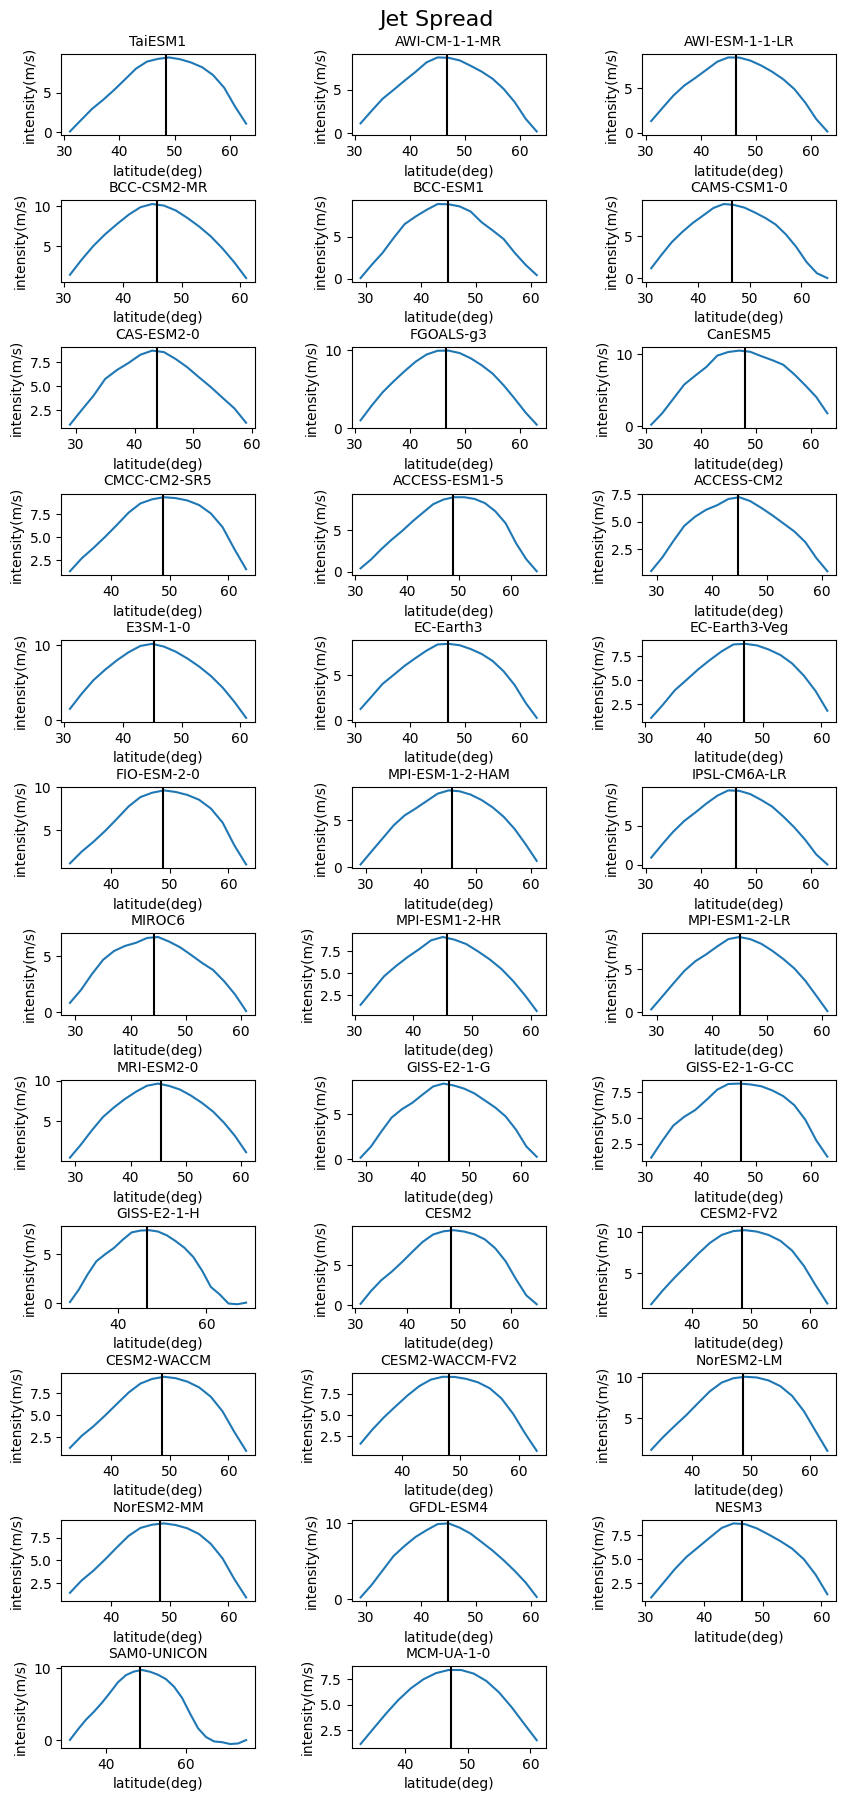

In [29]:
fig,ax = plt.subplots(nrows=int(len(models_atmos)/3)+1, ncols=3, figsize=(10,22))
fig.subplots_adjust(hspace=0.8, wspace=0.5)
for i in range(int(len(models_atmos)/3)+1): #ciclo sulle righe
    for j in range(3): #ciclo sulle colonne
        models_index_list = i * 3 + j #indice del modello all'interno della lista
        if models_index_list == len(models_list_atmos):
            break
        name = models_list_atmos[models_index_list]
        data_array = models_atmos[name]['jet spread']
        data_array.plot(ax=ax[i, j])
        #Calcolo del valore medio della distribuzione
        mean_value = np.sum(data_array.lat*data_array) / np.sum(data_array) #valor medio ponderato con intensità e latitudini
        ax[i,j].axvline(mean_value,color='black')
        ax[i,j].set_xlabel('latitude(deg)')
        ax[i,j].set_ylabel('intensity(m/s)')   
        ax[i,j].set_title(f'{name}', fontsize=10)
ax[int(len(models_atmos)/3),3-1].axis('off')
fig.suptitle('Jet Spread', fontsize=16, y=0.9)

In [30]:
def normal_tests(model):
    list_tests = []
    list_tests.append(stats.normaltest(model)) #gaussian test
    list_tests.append(stats.skewtest(model)) #skewness test
    list_tests.append(stats.kurtosistest(model)) #kurtosis test
    return list_tests

In [31]:
#test di normalità, skewness, kurtosis
for n in range(n_clusters):
    print(f'Cluster {n} with {len(list_clusters[n])} models')
    clusters_test = normal_tests(jet_spread_cluster_mean[n])
    if clusters_test[0].pvalue < 0.05:
        print(f'Cluster mean: \n Gaussian test p-value = {clusters_test[0].pvalue:.4f} < 0.05, \n Skewness test p-value = {clusters_test[1].pvalue:.4f}, \n Kurtosis test p-value = {clusters_test[2].pvalue:.4f}')
    #Modelli
    for i in range(len(list_clusters[n])):
        models_test = normal_tests(models_atmos[list_clusters[n][i]]['jet spread'])
        print(list_clusters[n][i], models_test)
        if models_test[0].pvalue < 0.05:
            print(list_clusters[n][i],f': \n Gaussian test p-value = {models_test[0].pvalue:.4f} < 0.05, \n Skewness test p-value = {models_test[1].pvalue:.4f}, \n Kurtosis test p-value = {models_test[2].pvalue:.4f}')
#Multi model
multi_model_test = normal_tests(jet_spread_model_mean)
if multi_model_test[0].pvalue < 0.05:
    print(f'Multi model mean: \n Gaussian test p-value = {multi_model_test[0].pvalue:.4f} < 0.05, \n Skewness test p-value = {multi_model_test[1].pvalue:.4f}, \n Kurtosis test p-value = {multi_model_test[2].pvalue:.4f}')

#Normal Test p-value > 0.05 hp nulla non si può rifiutare, i dati sembrano seguire una distrib normale
#Skewness test p-value > 0.05 non si può rifiutare l'hp di asimmetria nulla
#Kurtosis test p-value > 0.05 non si può rifiutare l'hp di kurtosis normale (=3)
#statistic = s^2 + k^2 (per distribuzione normale skweness = 0, kurtosis = 3)

Cluster 0 with 4 models
CAMS-CSM1-0 [NormaltestResult(statistic=2.9411199108602446, pvalue=0.22979677320262032), SkewtestResult(statistic=-0.9559601042727237, pvalue=0.33909239103092437), KurtosistestResult(statistic=-1.4238188753837784, pvalue=0.15449891024580967)]
CanESM5 [NormaltestResult(statistic=2.118918686618369, pvalue=0.34664317462730077), SkewtestResult(statistic=-1.1453566921403162, pvalue=0.25206143052220653), KurtosistestResult(statistic=-0.8983744956240478, pvalue=0.36898592885785064)]
E3SM-1-0 [NormaltestResult(statistic=1.7489250679368114, pvalue=0.41708612907414633), SkewtestResult(statistic=-1.0157590296803505, pvalue=0.3097441504320678), KurtosistestResult(statistic=-0.8468522076251819, pvalue=0.39707750412286225)]
NESM3 [NormaltestResult(statistic=1.8705934580307177, pvalue=0.3924693911957076), SkewtestResult(statistic=-1.0144100411066965, pvalue=0.31038713500305803), KurtosistestResult(statistic=-0.9173689151767831, pvalue=0.3589493559063469)]
Cluster 1 with 7 mode

/home/guest/work/sbeltrami/tesi/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1971: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  k, _ = kurtosistest(a, axis)
/tmp/ipykernel_1139572/947810954.py:5: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  list_tests.append(stats.kurtosistest(model)) #kurtosis test
/home/guest/work/sbeltrami/tesi/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1971: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  k, _ = kurtosistest(a, axis)
/tmp/ipykernel_1139572/947810954.py:5: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  list_tests.append(stats.kurtosistest(model)) #kurtosis test
/home/guest/work/sbeltrami/tesi/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1971: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  k, _ = kurtosistest(a, axis)
/tmp/ipykernel_1139572/947810954.py:5: UserWarning: ku

In [32]:
def std_weighted(model):
    mean_value = np.sum(model.lat*model) / np.sum(model) #valor medio ponderato con intensità e latitudini
    std = np.sqrt(np.sum(model*(model.lat - mean_value)**2)/np.sum(model))
    return std

In [33]:
#Calcolo della standard deviation poiché per soltanto due modelli si può riiutare l'hp di normalità
#Modelli
for name in models_atmos.keys():
    models_atmos[name]['jet spread'] = std_weighted(models_atmos[name]['jet spread'])#.std()
#Cluster
for n in range(n_clusters):
    jet_spread_cluster_mean[n] = std_weighted(jet_spread_cluster_mean[n])#.std()
#Multi model
jet_spread_model_mean = std_weighted(jet_spread_model_mean)#.std()

Plot

Text(0.5, 0.98, '850 hPa: Scatter plot Jet Stream intensity')

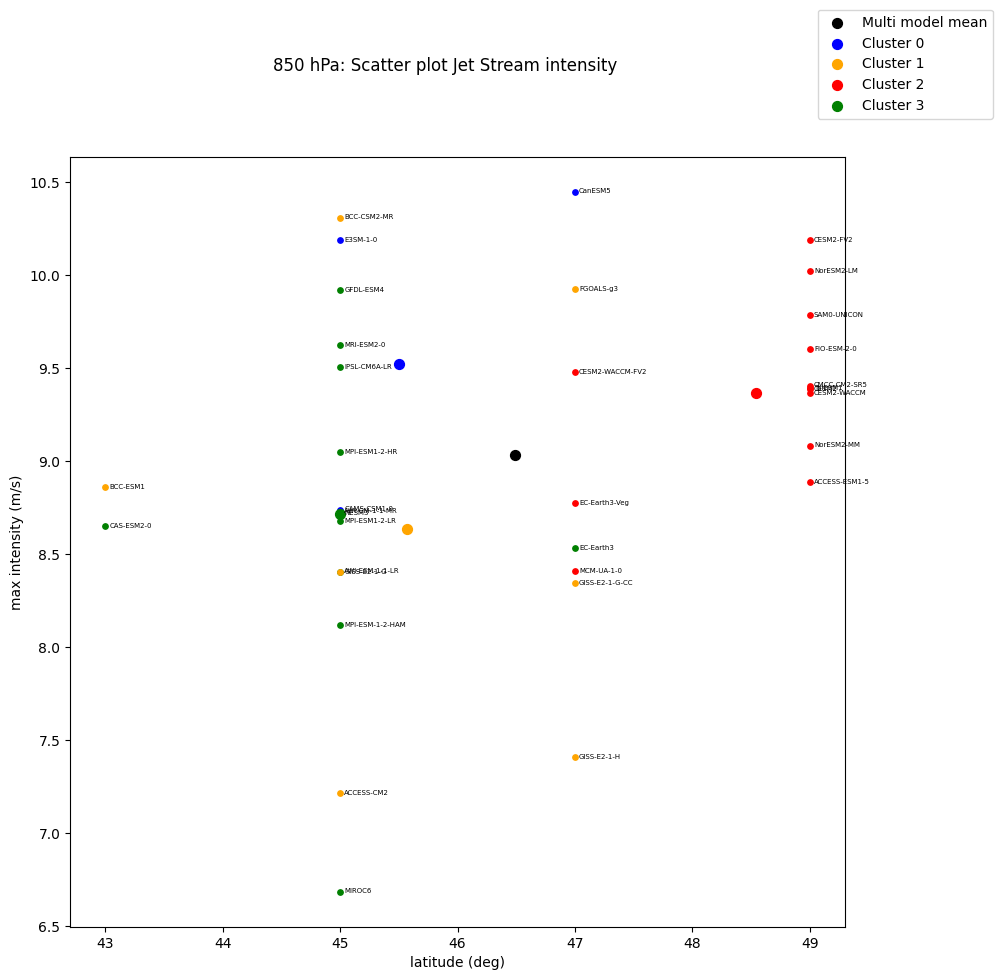

In [34]:
#Intensity-Latitude plot
fig,ax = plt.subplots(figsize=(10,10))
colour_list = ['black','blue','orange','red','green']
ax.scatter(latitude_jet_model_mean,intensity_jet_model_mean,s=50,color=colour_list[0],label='Multi model mean')
for name in models_atmos.keys():
    for n in range(len(list_clusters)): #ciclo sui cluster
        if name in list_clusters[n]: #se un modello appartiene ad un determinato cluster
            ax.scatter(models_atmos[name]['jet latitude'].values,models_atmos[name]['jet intensity'].values,s=15,color=colour_list[n+1])
            ax.annotate(name, (models_atmos[name]['jet latitude'].values,
                                models_atmos[name]['jet intensity'].values),
                        textcoords="offset points", xytext=(3,-1), ha='left',fontsize=5)
#Plot di ogni cluster
for n in range(len(list_clusters)):
    ax.scatter(latitude_jet_cluster_mean[n],intensity_jet_cluster_mean[n],label=f'Cluster {n}',s=50,color=colour_list[n+1])
ax.legend(loc='upper right',bbox_to_anchor=(1.2, 1.2))
ax.set_xlabel('latitude (deg)')
ax.set_ylabel('max intensity (m/s)')
fig.suptitle('850 hPa: Scatter plot Jet Stream intensity')

Text(0.5, 0.98, '850 hPa: Scatter plot Jet Stream tilt')

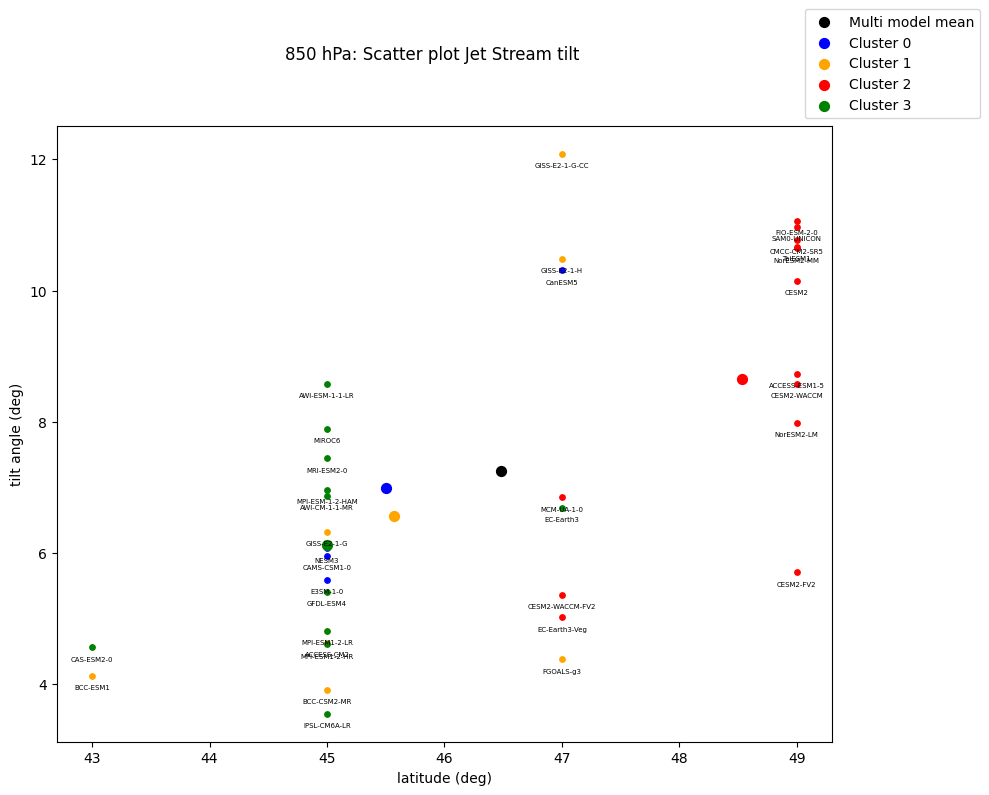

In [35]:
#Plot del jet tilt
fig,ax = plt.subplots(figsize=(10,8))
ax.scatter(latitude_jet_model_mean,jet_tilt_model_mean,s=50,color=colour_list[0],label='Multi model mean')
for name in models_atmos.keys():
    for n in range(len(list_clusters)): #ciclo sui cluster
        if name in list_clusters[n]: #se un modello appartiene ad un determinato cluster
            ax.scatter(models_atmos[name]['jet latitude'].values,models_atmos[name]['jet tilt'].values,s=15,color=colour_list[n+1])
            ax.annotate(name, (models_atmos[name]['jet latitude'].values,
                                models_atmos[name]['jet tilt'].values),
                        textcoords="offset points", xytext=(0,-10), ha='center',fontsize=5)
#Plot di ogni cluster
for n in range(len(list_clusters)):
    ax.scatter(latitude_jet_cluster_mean[n],jet_tilt_cluster_mean[n],label=f'Cluster {n}',s=50,color=colour_list[n+1])
ax.legend(loc='upper right',bbox_to_anchor=(1.2, 1.2))
ax.set_xlabel('latitude (deg)')
ax.set_ylabel('tilt angle (deg)')
fig.suptitle('850 hPa: Scatter plot Jet Stream tilt')

Text(0.5, 0.98, '850 hPa: Scatter plot Jet Stream spread')

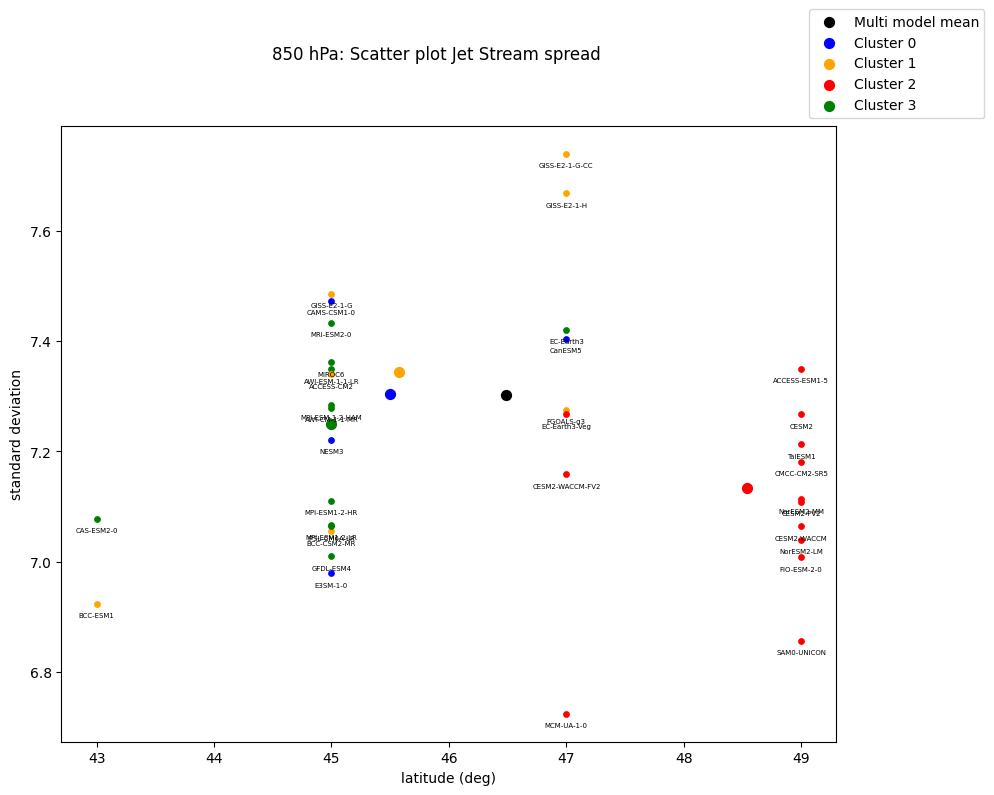

In [36]:
#Plot dello spread del jet
fig,ax = plt.subplots(figsize=(10,8))
ax.scatter(latitude_jet_model_mean,jet_spread_model_mean,s=50,color=colour_list[0],label='Multi model mean')
for name in models_atmos.keys():
    for n in range(len(list_clusters)): #ciclo sui cluster
        if name in list_clusters[n]: #se un modello appartiene ad un determinato cluster
            ax.scatter(models_atmos[name]['jet latitude'].values,models_atmos[name]['jet spread'].values,s=15,color=colour_list[n+1])
            ax.annotate(name, (models_atmos[name]['jet latitude'].values,
                                models_atmos[name]['jet spread'].values),
                        textcoords="offset points", xytext=(0,-10), ha='center',fontsize=5)
#Plot di ogni cluster
for n in range(len(list_clusters)):
    ax.scatter(latitude_jet_cluster_mean[n],jet_spread_cluster_mean[n],label=f'Cluster {n}',s=50,color=colour_list[n+1])
ax.legend(loc='upper right',bbox_to_anchor=(1.2, 1.2))
ax.set_xlabel('latitude (deg)')
ax.set_ylabel('standard deviation')
fig.suptitle('850 hPa: Scatter plot Jet Stream spread')

Altro procedimento: non uso la climatology mean, cioè prendo il vento mediato mensilmente, calcolo il massimo e poi calcolo la media climatologica.
Meglio il procedimento sopra perché la variabilità del vento è ad alta frequenza (variazione giornaliera), quindi meglio utilizzare direttamente la media climatologica --> cancellato

Plot di intensità del jet stream di ogni modello, di ogni cluster, della multi model mean

TypeError: No numeric data to plot.

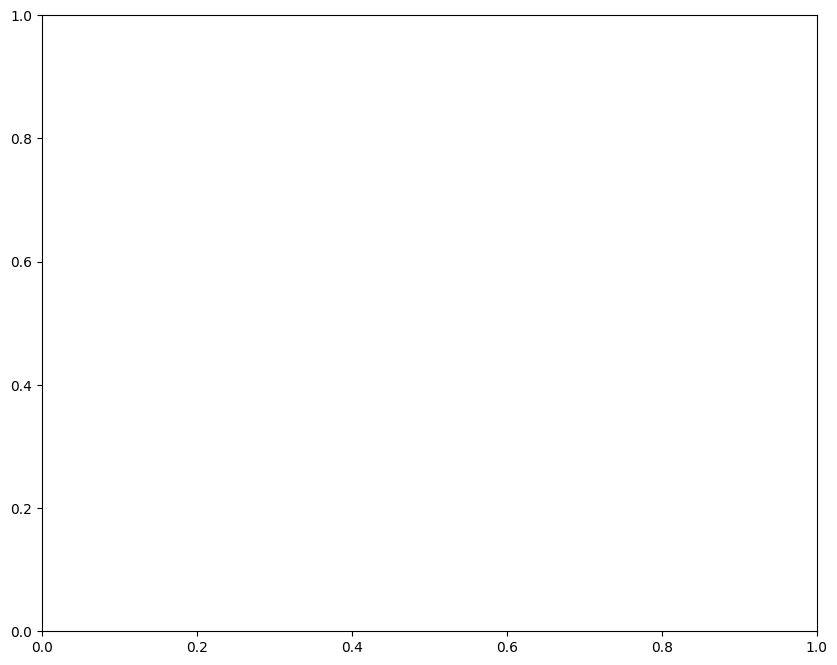

In [37]:
fig,ax = plt.subplots(figsize=(10,8))
#Plot della multi model mean
intensity_jet_model_mean.plot(ax=ax,label='Multi model mean',color=colour_list[0],linewidth=2)
#Plot di ogni modello
for name in models_atmos.keys(): #ciclo sui modelli
    for n in range(len(list_clusters)): #ciclo sui cluster
        if name in list_clusters[n]: #se un modello appartiene ad un determinato cluster
            models_atmos[name]['jet intensity'].plot(ax=ax,color=colour_list[n+1]) #label=f'{name}',
            #ax.annotate(name, xy=(models_atmos[name]['jet intensity'].coords['lon'].values[-1], models_atmos[name]['jet intensity'].values[-1]), 
            #            xytext=(5, 0), textcoords='offset points', color=colour_list[n+1])
#Plot di ogni cluster
for n in range(len(list_clusters)):
    intensity_jet_cluster_mean[n].plot(ax=ax,label=f'Cluster {n}',linestyle='-.',color=colour_list[n+1])
ax.legend(loc='upper right')
ax.set_ylabel('intensity (m/s)')
ax.set_xlabel('longitude (deg)')
fig.suptitle('850 hPa : Jet Stream intensity')

Plot della latitudine del jet stream di ogni modello, di ogni cluster, della multi model mean

Text(0.5, 0.98, '850 hPa : Jet Stream latitude')

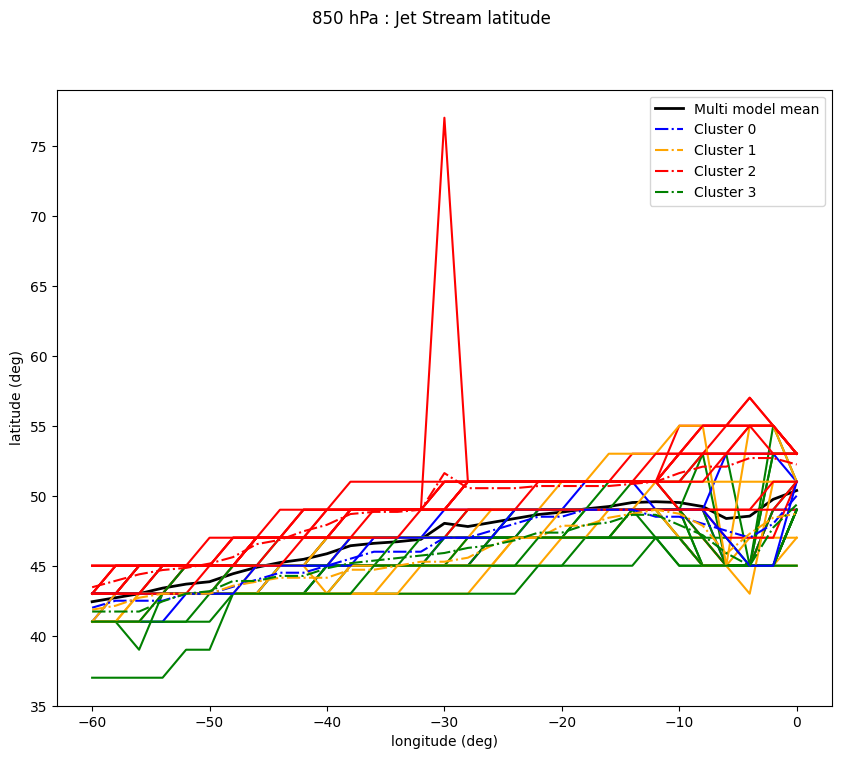

In [ ]:
fig,ax = plt.subplots(figsize=(10,8))
#Plot della multi model mean
latitude_jet_model_mean.plot(ax=ax,label='Multi model mean',color=colour_list[0],linewidth=2)
#Plot di ogni modello
for name in models_atmos.keys(): #ciclo sui modelli
    for n in range(len(list_clusters)): #ciclo sui cluster
        if name in list_clusters[n]: #se un modello appartiene ad un determinato cluster
            models_atmos[name]['jet latitude'].plot(ax=ax,color=colour_list[n+1])#label=f'{name}',
#Plot di ogni cluster
for n in range(len(list_clusters)):
    latitude_jet_cluster_mean[n].plot(ax=ax,label=f'Cluster {n}',linestyle='-.',color=colour_list[n+1])
ax.legend(loc='upper right')
ax.set_ylabel('latitude (deg)')
ax.set_xlabel('longitude (deg)')
fig.suptitle('850 hPa : Jet Stream latitude')

300 hPa

In [ ]:
for name in models_zonmean.keys():
    #Considero soltanto il livello a 300 hPa
    dataset = models_zonmean[name]['zonmean remap period 1982 2014'][:,7,:,:].sel(lat=slice(20,80)) #300hPa
    lon_neg = dataset.sel(lon=slice(300,360))
    # Seleziono la parte delle lon positive
    lon_pos = dataset.sel(lon=slice(0))
    # Concateno i due subset lungo la dimensione 'lon'
    lon_concat = xr.concat([lon_neg,lon_pos], dim='lon')
    dataset = lon_concat.assign_coords(lon=(np.where(lon_concat.lon >= 300, lon_concat.lon - 360, lon_concat.lon)))
    #Calcolo la media climatologica nel solito periodo 1982-2014
    models_zonmean[name]['atmos box jet climatology'] = compute_mean_resample_mar(dataset ,"1982","2014",3)

Determino il massimo dell'intensità del vento sulla media climatologica, poi faccio multi model mean e cluster mean dei massimi.
Calcolo la latitudine del jet come la latitudine a cui si ha intensità massima del jet

In [ ]:
lat_coords = models_zonmean['ACCESS-CM2']['atmos box jet climatology'].coords['lat']
zonmean_intensity_jet_cluster_mean = []
zonmean_latitude_jet_cluster_mean = []
#Inizializzo xarray
sum_models_latitude = 0
sum_models_intensity = 0
#CLUSTER
for n in range(n_clusters):  # ciclo su ogni cluster
    sum_clusters_intensity = 0
    sum_clusters_latitude = 0
    #MODELLI
    for i in range(len(list_clusters[n])):  # ciclo su ogni modello dei singoli cluster
        name = list_clusters[n][i] #nome modello
        #Calcolo media zonale e poi determino il massimo per ogni latitudine
        zonal_mean = models_zonmean[name]['atmos box jet climatology'].mean(dim='lon')
        models_zonmean[name]['jet intensity'] = zonal_mean.max() #il massimo sulla latitudine
        models_zonmean[name]['jet latitude'] = (np.nanargmax(zonal_mean))*2 + models_zonmean[name]['atmos box jet climatology'].lat[0] #sommo lat[0] per avere il giusto valore di latitudine
        #Somma per ogni modello per ogni longitudine, di uno specifico cluster
        sum_clusters_intensity = sum_clusters_intensity + models_zonmean[name]['jet intensity']
        sum_clusters_latitude = sum_clusters_latitude + models_zonmean[name]['jet latitude']
    #Clusters' mean per ogni longitudine
    zonmean_intensity_jet_cluster_mean.append((sum_clusters_intensity / len(list_clusters[n])))
    zonmean_latitude_jet_cluster_mean.append((sum_clusters_latitude / len(list_clusters[n])))
    #Somma su tutti i modello per ogni longitudine, per la model mean    
    sum_models_intensity = sum_models_intensity + sum_clusters_intensity
    sum_models_latitude = sum_models_latitude + sum_clusters_latitude
#Multi model mean per ogni longitudine
zonmean_intensity_jet_model_mean = sum_models_intensity / len(models_zonmean)
zonmean_latitude_jet_model_mean = sum_models_latitude / len(models_zonmean)

Text(0.5, 0.98, '300 hPa : Scatter plot Jet Stream intensity')

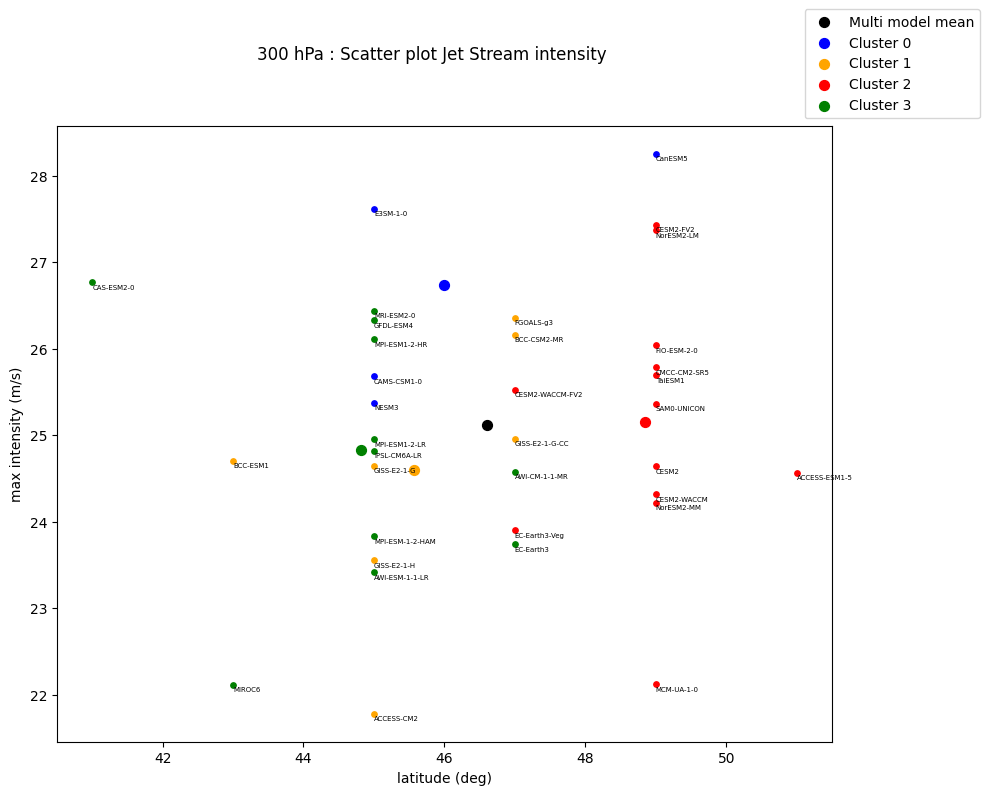

In [ ]:
fig,ax = plt.subplots(figsize=(10,8))
ax.scatter(zonmean_latitude_jet_model_mean,zonmean_intensity_jet_model_mean,s=50,color=colour_list[0],label='Multi model mean')
for name in models_zonmean.keys():
    for n in range(len(list_clusters)): #ciclo sui cluster
        if name in list_clusters[n]: #se un modello appartiene ad un determinato cluster
            ax.scatter(models_zonmean[name]['jet latitude'].values,models_zonmean[name]['jet intensity'].values,s=15,color=colour_list[n+1])
            ax.annotate(name, (models_zonmean[name]['jet latitude'].values,
                                models_zonmean[name]['jet intensity'].values),
                        textcoords="offset points", xytext=(0,-5), ha='left',fontsize=5)
#Plot di ogni cluster
for n in range(len(list_clusters)):
    ax.scatter(zonmean_latitude_jet_cluster_mean[n],zonmean_intensity_jet_cluster_mean[n],label=f'Cluster {n}',s=50,color=colour_list[n+1])
ax.legend(loc='upper right',bbox_to_anchor=(1.2, 1.2))
ax.set_xlabel('latitude (deg)')
ax.set_ylabel('max intensity (m/s)')
fig.suptitle('300 hPa : Scatter plot Jet Stream intensity')

Plot di intensità del jet stream di ogni modello, di ogni cluster, della multi model mean

Text(0.5, 0.98, '300 hPa: Jet Stream intensity')

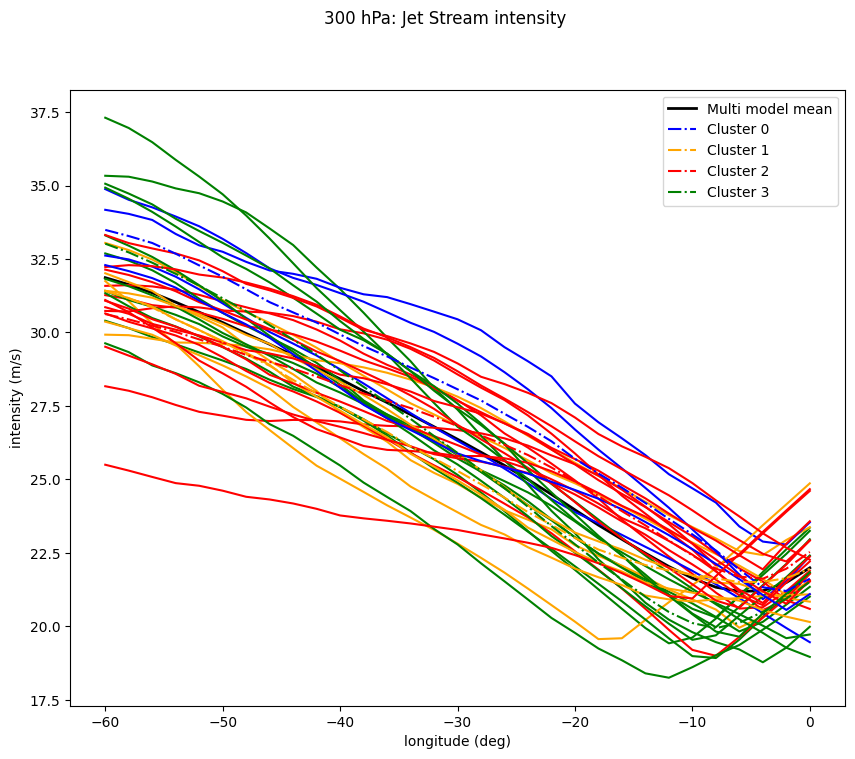

In [ ]:
fig,ax = plt.subplots(figsize=(10,8))
#Plot della multi model mean
zonmean_intensity_jet_model_mean.plot(ax=ax,label='Multi model mean',color=colour_list[0],linewidth=2)
#Plot di ogni modello
for name in models_zonmean.keys(): #ciclo sui modelli
    for n in range(len(list_clusters)): #ciclo sui cluster
        if name in list_clusters[n]: #se un modello appartiene ad un determinato cluster
            models_zonmean[name]['jet intensity'].plot(ax=ax,color=colour_list[n+1]) #label=f'{name}',
            #ax.annotate(name, xy=(models_atmos[name]['jet intensity'].coords['lon'].values[-1], models_atmos[name]['jet intensity'].values[-1]), 
            #            xytext=(5, 0), textcoords='offset points', color=colour_list[n+1])
#Plot di ogni cluster
for n in range(len(list_clusters)):
    zonmean_intensity_jet_cluster_mean[n].plot(ax=ax,label=f'Cluster {n}',linestyle='-.',color=colour_list[n+1])
ax.legend(loc='upper right')
ax.set_ylabel('intensity (m/s)')
ax.set_xlabel('longitude (deg)')
fig.suptitle('300 hPa: Jet Stream intensity')

Plot della latitudine del jet stream di ogni modello, di ogni cluster, della multi model mean

Text(0.5, 0.98, '300 hPa : Jet Stream latitude')

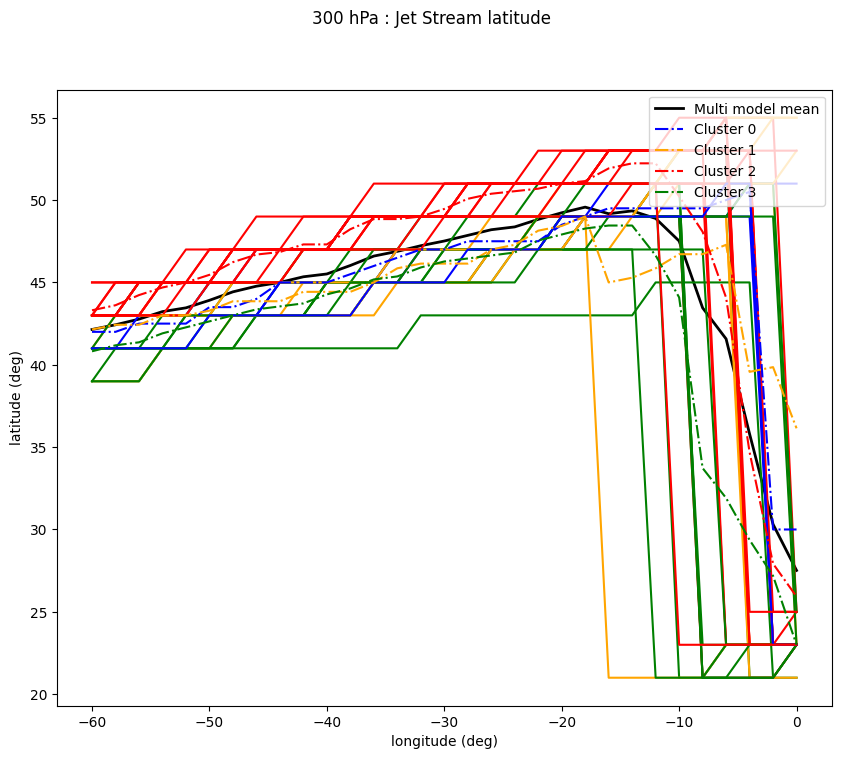

In [ ]:
fig,ax = plt.subplots(figsize=(10,8))
#Plot della multi model mean
zonmean_latitude_jet_model_mean.plot(ax=ax,label='Multi model mean',color=colour_list[0],linewidth=2)
#Plot di ogni modello
for name in models_zonmean.keys(): #ciclo sui modelli
    for n in range(len(list_clusters)): #ciclo sui cluster
        if name in list_clusters[n]: #se un modello appartiene ad un determinato cluster
            models_zonmean[name]['jet latitude'].plot(ax=ax,color=colour_list[n+1])#label=f'{name}',
#Plot di ogni cluster
for n in range(len(list_clusters)):
    zonmean_latitude_jet_cluster_mean[n].plot(ax=ax,label=f'Cluster {n}',linestyle='-.',color=colour_list[n+1])
ax.legend(loc='upper right')
ax.set_ylabel('latitude (deg)')
ax.set_xlabel('longitude (deg)')
fig.suptitle('300 hPa : Jet Stream latitude')

Salvataggio in file pickle

In [ ]:
with open('jet_stream_intensity_latitude.pkl', 'wb') as file:
    dill.dump(models_atmos, file)
    dill.dump(models_zonmean, file)
    #Clusters
    dill.dump(intensity_jet_cluster_mean,file)
    dill.dump(latitude_jet_cluster_mean,file)
    dill.dump(zonmean_intensity_jet_cluster_mean,file)
    dill.dump(zonmean_latitude_jet_cluster_mean,file)
    #Model
    dill.dump(intensity_jet_model_mean,file)
    dill.dump(latitude_jet_model_mean,file)
    dill.dump(zonmean_intensity_jet_model_mean,file)
    dill.dump(zonmean_latitude_jet_model_mean,file)